In [214]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


# load model and get predictions

In [215]:
model = tf.keras.models.load_model("models_xception_old/saved-model-02-0.83.h5")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,879,923 (79.65 MB)

 Trainable params: 20,825,393 (79.44 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 2 (12.00 B)

In [216]:
image_path = 'data/images/'

random_seed = 42
img_size = 299
batch_size = 1
val = tf.keras.utils.image_dataset_from_directory(
  image_path,
  validation_split=0.1,
  subset="validation",
  seed=random_seed,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical",
)

Found 9632 files belonging to 9 classes.
Using 963 files for validation.


In [217]:
fixed_val = val.cache()

In [218]:
class_names = val.class_names

In [219]:
X_val = np.concatenate([X for X, y in fixed_val])
y_val = np.concatenate([y for X, y in fixed_val])
y_class_indices = np.argmax(y_val, axis=1)

In [220]:
predictions = model.predict(X_val)


31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step


In [221]:
predicted_classes = np.argmax(predictions, axis=1)


# XAI

## simple metrics on validation set

In [222]:
accuracy = accuracy_score(y_class_indices, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8339


In [223]:
from sklearn.metrics import classification_report

print(classification_report(y_class_indices, predicted_classes, target_names=class_names))


              precision    recall  f1-score   support

        A549       0.84      0.79      0.82        53
      CACO-2       0.75      0.97      0.84       163
     HEK_293       0.92      0.66      0.77       131
        HeLa       0.87      0.59      0.70        58
        MCF7       0.93      0.90      0.91       113
        PC-3       0.98      0.84      0.91        76
         RT4       1.00      0.84      0.92       231
    U-251_MG       0.85      0.73      0.79        63
      U-2_OS       0.52      1.00      0.69        75

    accuracy                           0.83       963
   macro avg       0.85      0.81      0.82       963
weighted avg       0.87      0.83      0.84       963



good score on **RT4**, which is the overrepresented group in the dataset. Also **PC-3** and **MCF7** shows a good score over all three metrics.<br>
Eventhough **CACO-2** occurs more often in the dataset, it shows a low accuary <br>
**U-2 OS** shows low score, eventhough other groups occur equally often  <br>
Below we see the distribution again.

<BarContainer object of 9 artists>

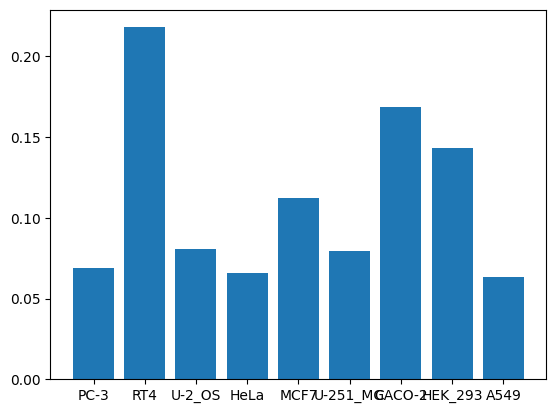

In [224]:
classes_distr = {'PC-3': 0.06883305647840532, 'RT4': 0.2180232558139535, 'U-2_OS': 0.0804609634551495, 'HeLa': 0.06561461794019934, 'MCF7': 0.11233388704318936, 'U-251_MG': 0.07973421926910298, 'CACO-2': 0.168812292358804, 'HEK_293': 0.14306478405315615, 'A549': 0.06312292358803986}

plt.bar(classes_distr.keys(), classes_distr.values())

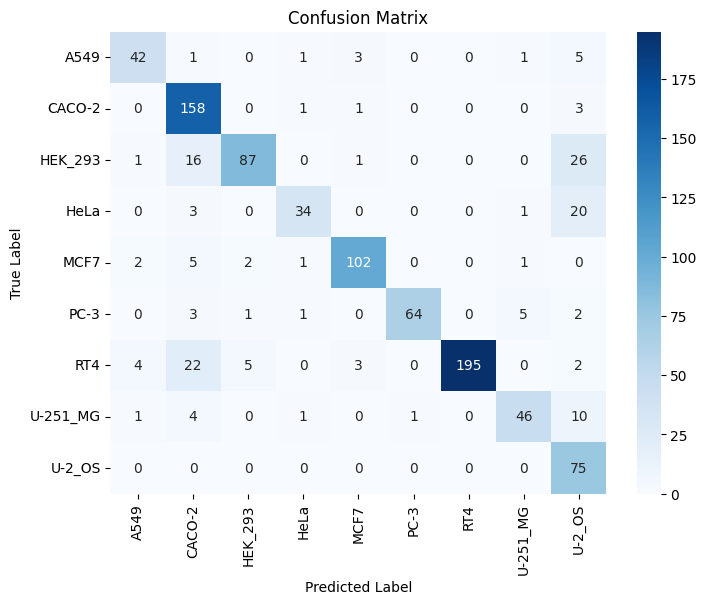

In [225]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_class_indices, predicted_classes)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


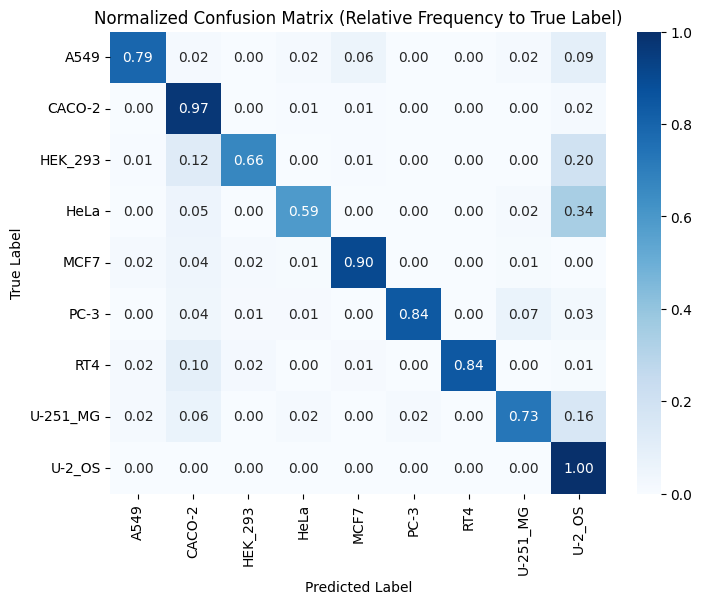

In [226]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Relative Frequency to True Label)")
plt.show()


We can see that the model has a hard time classifying HEK 293 and HeLa and oftentimes classify these two classes as U-2 OS. We see that the classes HEK 293, A549, HeLa, U-251 MG are often misclassified as U-2 OS. We also see that U-2 OS is never misclassified. 

In [227]:
conf_matrix

array([[ 42,   1,   0,   1,   3,   0,   0,   1,   5],
       [  0, 158,   0,   1,   1,   0,   0,   0,   3],
       [  1,  16,  87,   0,   1,   0,   0,   0,  26],
       [  0,   3,   0,  34,   0,   0,   0,   1,  20],
       [  2,   5,   2,   1, 102,   0,   0,   1,   0],
       [  0,   3,   1,   1,   0,  64,   0,   5,   2],
       [  4,  22,   5,   0,   3,   0, 195,   0,   2],
       [  1,   4,   0,   1,   0,   1,   0,  46,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,  75]])

In [228]:
conf_matrix.astype('float') / conf_matrix.sum(axis=0)[:, np.newaxis]

array([[0.84      , 0.02      , 0.        , 0.02      , 0.06      ,
        0.        , 0.        , 0.02      , 0.1       ],
       [0.        , 0.74528302, 0.        , 0.00471698, 0.00471698,
        0.        , 0.        , 0.        , 0.01415094],
       [0.01052632, 0.16842105, 0.91578947, 0.        , 0.01052632,
        0.        , 0.        , 0.        , 0.27368421],
       [0.        , 0.07692308, 0.        , 0.87179487, 0.        ,
        0.        , 0.        , 0.02564103, 0.51282051],
       [0.01818182, 0.04545455, 0.01818182, 0.00909091, 0.92727273,
        0.        , 0.        , 0.00909091, 0.        ],
       [0.        , 0.04615385, 0.01538462, 0.01538462, 0.        ,
        0.98461538, 0.        , 0.07692308, 0.03076923],
       [0.02051282, 0.11282051, 0.02564103, 0.        , 0.01538462,
        0.        , 1.        , 0.        , 0.01025641],
       [0.01851852, 0.07407407, 0.        , 0.01851852, 0.        ,
        0.01851852, 0.        , 0.85185185, 0.18518519],


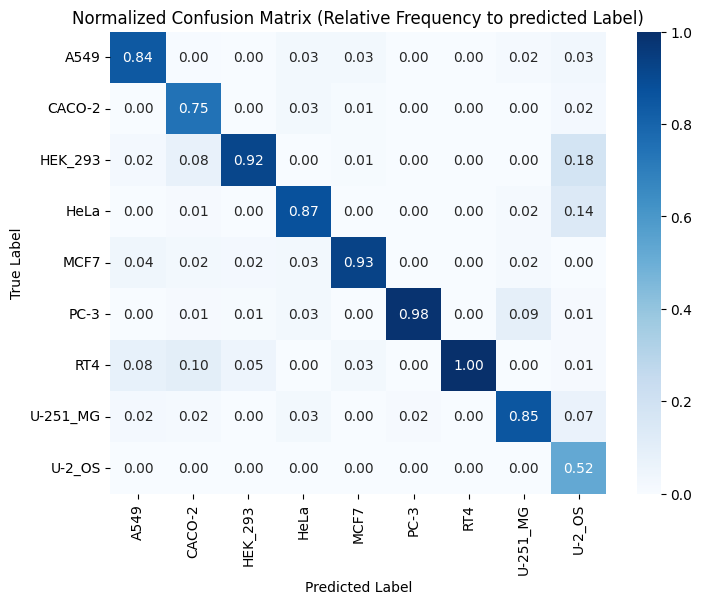

In [229]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Relative Frequency to predicted Label)")
plt.show()


If we normalize the confusion matrix corresponding to the predicted label, we see that the sample, which the model labels as U-2 OS are only correct in 52% of the time and that over 30 % are actually HEK 293 or HeLa

In [230]:
from tensorflow.keras.preprocessing import image

In [231]:
def load_and_preprocess_image(image_path, target_size=(299, 299)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    return img, np.expand_dims(img_array, axis=0)  # Add batch dimension


In [232]:
img_path = 'data/images/RT4/2.png'  # Replace with an actual image path
test_image,  test_image_array = load_and_preprocess_image(img_path)

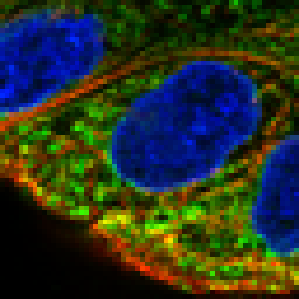

In [233]:
test_image

## SHAP

In [234]:
import shap

In [235]:
test_image_prediction = model.predict(test_image_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


['A549',
 'CACO-2',
 'HEK_293',
 'HeLa',
 'MCF7',
 'PC-3',
 'RT4',
 'U-251_MG',
 'U-2_OS']

In [263]:
np.argmax(test_image_prediction)


np.int64(4)

trying blur masker of size 32x32

In [236]:
# Define a masker that inpaints regions of the image
masker = shap.maskers.Image("blur(32,32)", test_image_array[0].shape)

# Create a SHAP explainer
explainer = shap.Explainer(model, masker, output_names=list(class_names.values()))
shap_values = explainer(test_image, max_evals=100) #, , batch_size=1outputs=shap.Explanation.argsort.flip[:1]


cv2 could not be imported!


ModuleNotFoundError: No module named 'cv2'

## LIME

In [238]:
from lime import lime_image


In [284]:

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Function to explain a prediction using LIME
def explain_with_lime(img,label):
    
    # Predict the class
    prediction = model.predict(img, verbose=0)
    print(prediction)
    print(f"Predicted class: {np.argmax(prediction)} with confidence {np.max(prediction)}")
    
    # Create the explanation for the image
    explanation = explainer.explain_instance(
        img[0],  
        model,  
        top_labels=3,  
        hide_color=0,  
        num_samples=500  
    )
    
    # Get the explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        label=label, #np.argmax(prediction),  
        positive_only=False,  
        hide_rest=False, 
        num_features=10
    )
    
    # Display the image with explanation
    plt.imshow(np.array(temp, dtype=int))
    plt.title(f"Explanation for class {class_names[label]}")
    plt.show()


In [285]:
img_path = 'data/images/MCF7/9443.png'  # Replace with an actual image path
test_image,  test_image_array = load_and_preprocess_image(img_path)

[[4.39939335e-11 7.36786658e-03 1.45795695e-10 7.67918351e-08
  9.92630839e-01 1.14261002e-06 2.01282685e-10 1.32799265e-08
  5.48704682e-09]]
Predicted class: 4 with confidence 0.9926308393478394


100%|██████████| 500/500 [02:00<00:00,  4.14it/s]


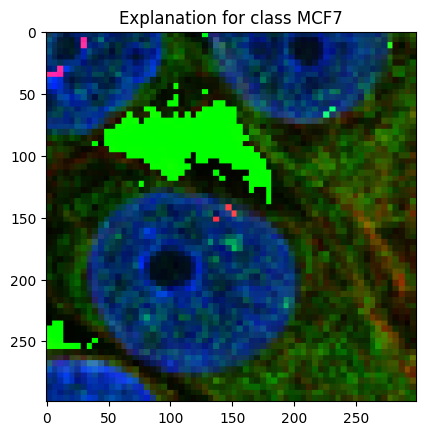

In [286]:
explain_with_lime(test_image_array, 4)


[[3.4606978e-02 1.6828129e-02 5.5546517e-04 7.8370249e-01 1.0235561e-02
  5.3608383e-05 3.7849011e-05 9.8886238e-05 1.5388106e-01]]
Predicted class: 3 with confidence 0.7837024927139282


100%|██████████| 500/500 [01:56<00:00,  4.28it/s]


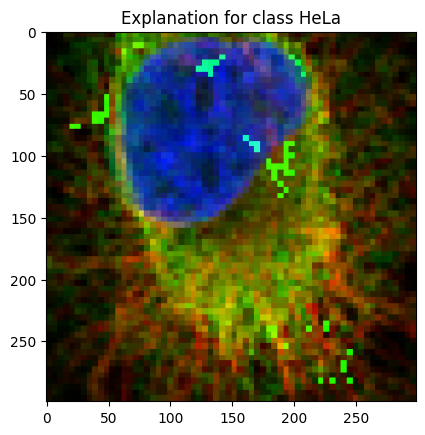

[[3.4606978e-02 1.6828129e-02 5.5546517e-04 7.8370249e-01 1.0235561e-02
  5.3608383e-05 3.7849011e-05 9.8886238e-05 1.5388106e-01]]
Predicted class: 3 with confidence 0.7837024927139282


100%|██████████| 500/500 [01:54<00:00,  4.37it/s]


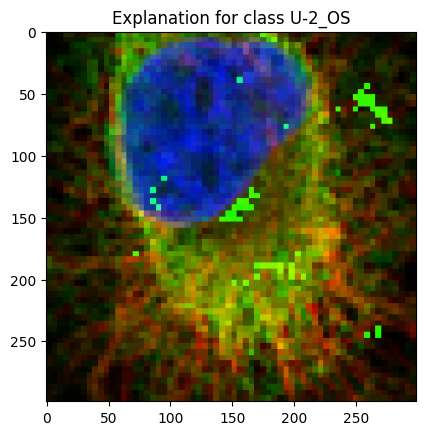

In [287]:
img_path = 'data/images/HeLa/57.png'
test_image,  test_image_array = load_and_preprocess_image(img_path)

explain_with_lime(test_image_array, 3)
explain_with_lime(test_image_array, 8)


Unfortunaley we do not see that the model focuses on specific or characteristic parts.